In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Pipelines: ML E2E Taxi using Spark ML

## Overview

This notebook shows how to build a Spark ML pipeline using Spark MLlib and DataprocPySparkBatchOp component to determine the fare of a Taxi ride. In particular, the pipeline covers a Spark MLib pipeline, from data preprocessing to training of a random forest regressor which predicts the fare of a taxi ride.

Learn more about [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) and [Dataproc components](https://cloud.google.com/vertex-ai/docs/pipelines/dataproc-component).

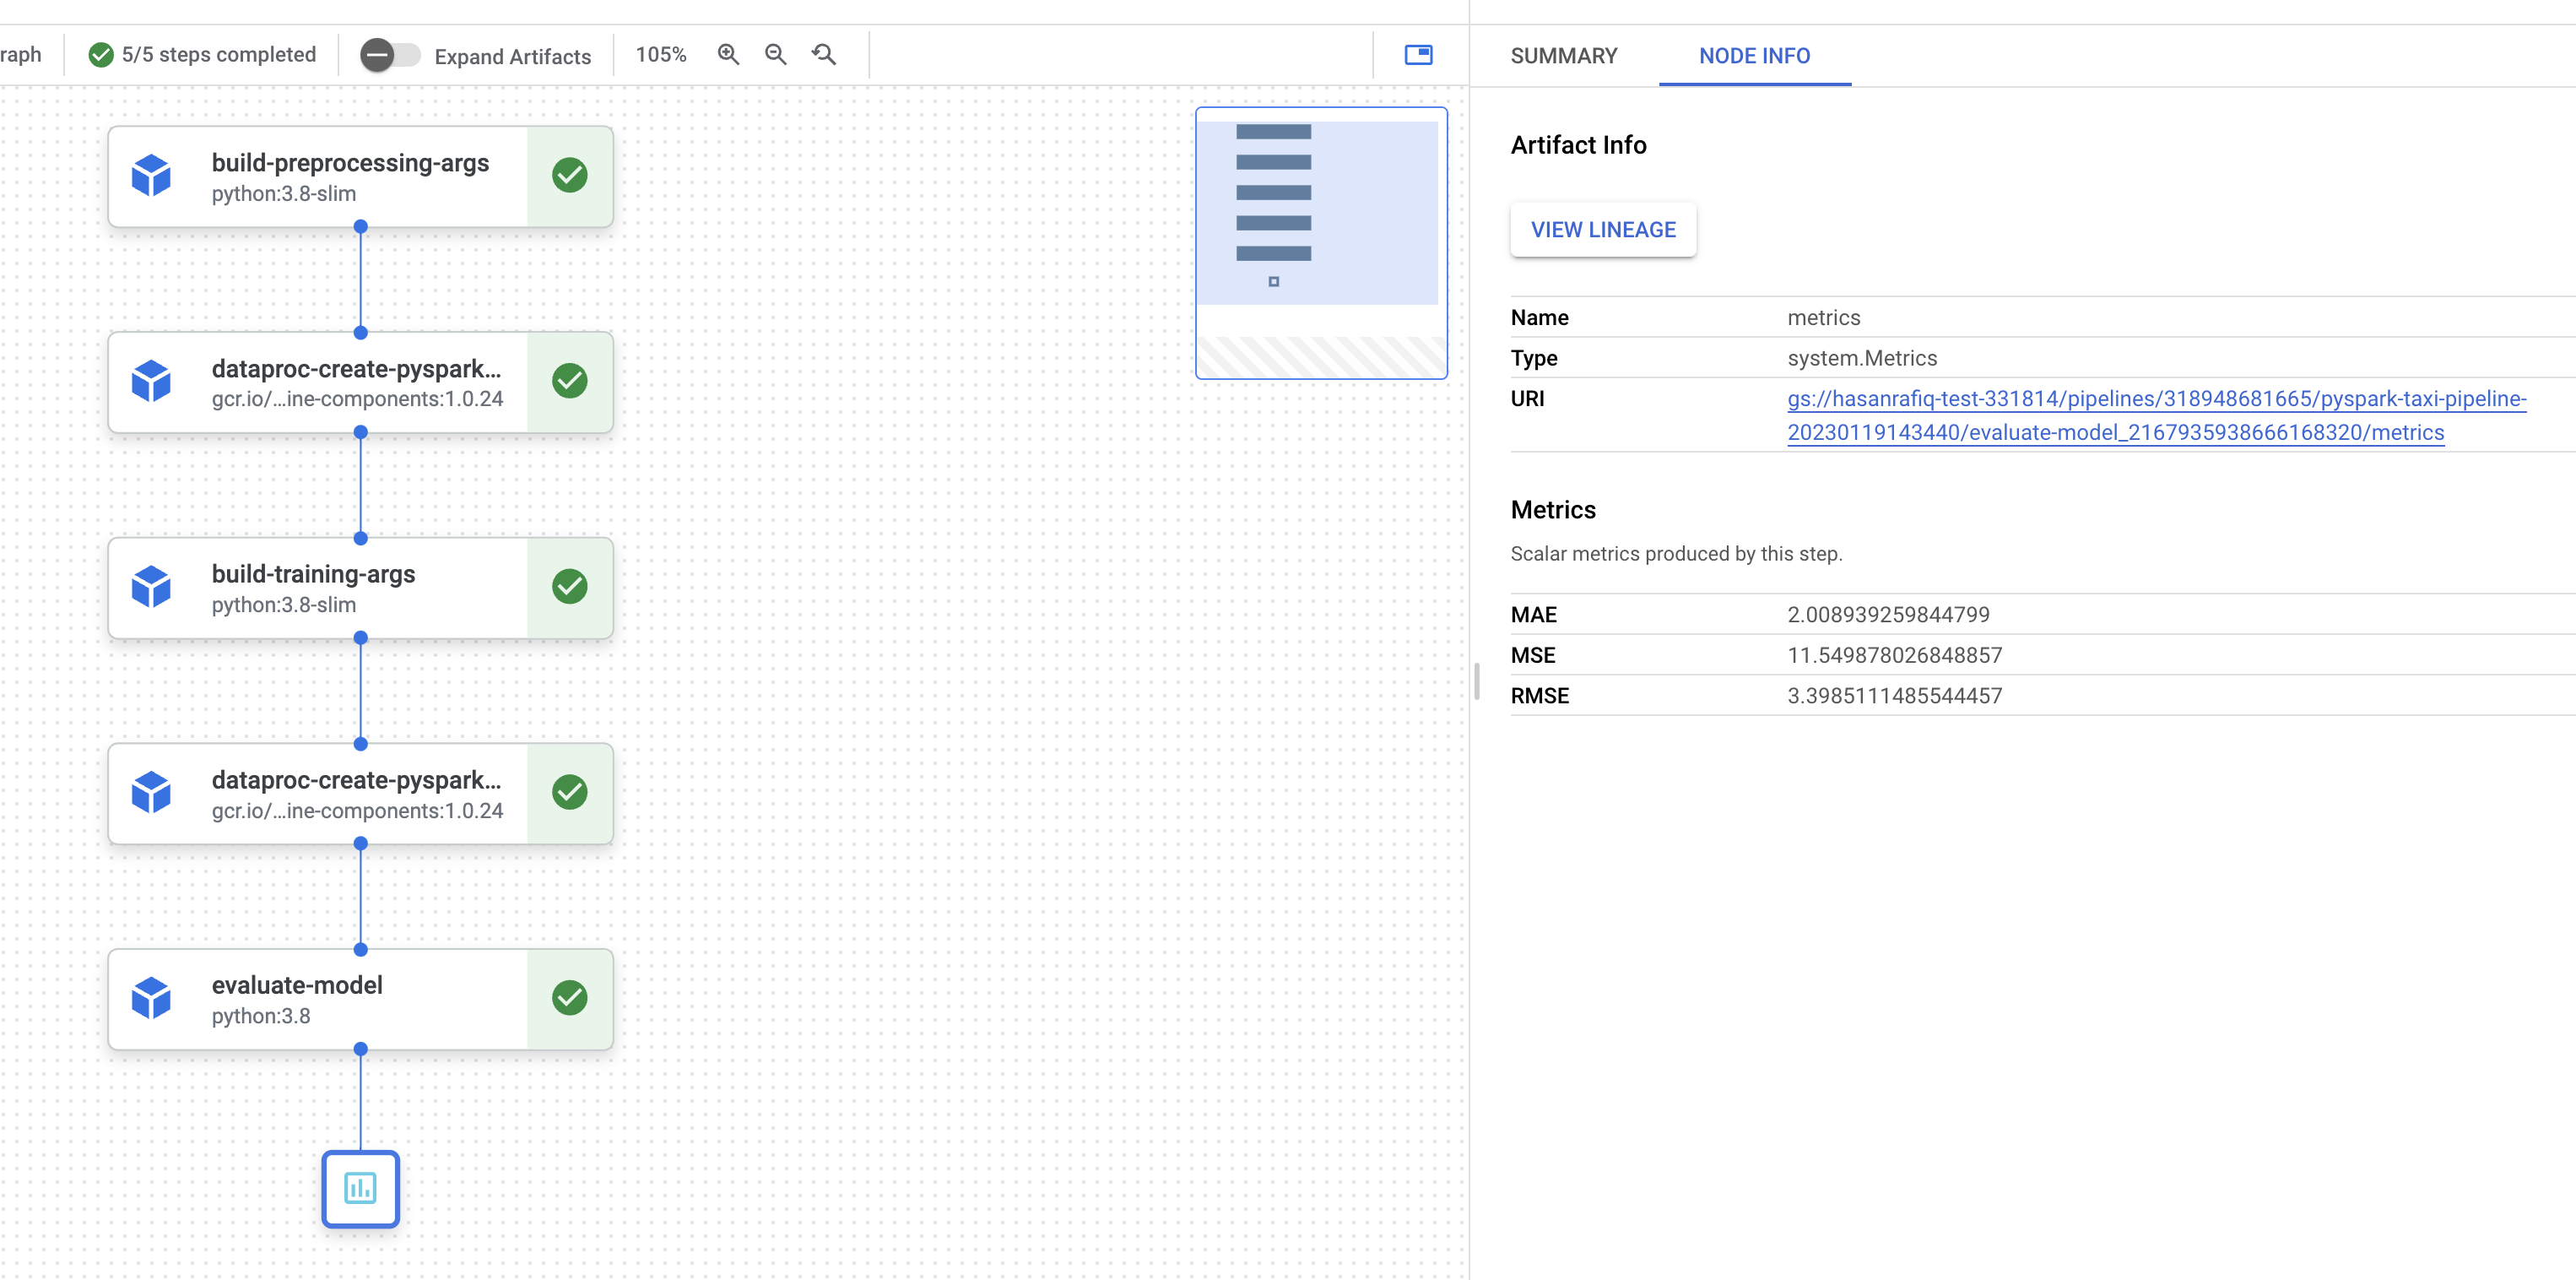

### Objective

In this notebook, you learn how to build a Vertex AI pipeline and train a Spark ML model

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Datasets
- Vertex AI Pipelines
- Vertex AI Training


The steps performed include:

*   Use the `DataprocPySparkBatchOp` to preprocess data.
*   Train a random forest model using PySpark.
*   Build a Vertex AI pipeline and run the training job on DataProc
*   Evaluate the model results

### Dataset

The dataset is a preprocessed version of the [taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage
* Dataproc Serverless

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), [Dataproc
pricing](https://cloud.google.com/dataproc/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

## Install additional packages

Install additional package dependencies not installed in your notebook environment, such as Pyspark and others. Use the latest major GA version of each package.

In [ ]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"
    
! pip3 install {USER_FLAG} --upgrade google-cloud-aiplatform==1.18.1 \
                                     kfp==1.8.14 \
                                     google-cloud-pipeline-components==1.0.24 --quiet --no-warn-conflicts

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Cloud Build, Cloud Storage, and Artifact Registry APIs.](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleleapis.com,%20cloudbuild.googleapis.com,%20storage-api.googleapis.com,%20artifactregistry.googleapis.com&_ga=2.11105652.1331351212.1648374605-1663626427.1647020959). 

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [ ]:
! gcloud config set project $PROJECT_ID --quiet

#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. It is recommended that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "[your-region]"  # @param {type:"string"}

In [ ]:
if REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type the following role and select them

      - Artifact Registry Administrator
      - Artifact Registry Repository Administrator
      - Cloud Build Editor
      - Compute Network Admin
      - Dataproc Administrator
      - Dataproc Worker
      - Service Account User
      - Storage Admin
      - Storage Object Admin
      - Vertex AI Administrator


5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
# # If you are running this notebook in Colab, run this cell and follow the
# # instructions to authenticate your GCP account. This provides access to your
# # Cloud Storage bucket and lets you submit training jobs and prediction
# # requests.

# import os
# import sys

# # If on Vertex AI Workbench, then don't execute this code
# IS_COLAB = "google.colab" in sys.modules
# if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
#     "DL_ANACONDA_HOME"
# ):
#     if "google.colab" in sys.modules:
#         from google.colab import auth as google_auth

#         google_auth.authenticate_user()

#     # If you are running this notebook locally, replace the string below with the
#     # path to your service account key and run this cell to authenticate your GCP
#     # account.
#     elif not os.getenv("IS_TESTING"):
#         %env GOOGLE_APPLICATION_CREDENTIALS ''

### Enable Google Cloud services

Enable the following services in your project:

* Artifact Registry
* Cloud Build
* Container Registry
* Dataproc
* Vertex AI


In [ ]:
! gcloud services enable \
    artifactregistry.googleapis.com \
    cloudbuild.googleapis.com \
    containerregistry.googleapis.com \
    dataproc.googleapis.com \
    aiplatform.googleapis.com

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a Spark job using the Cloud SDK, you need a bucket to read the python module associated and the data required to it. 

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

In [ ]:
BUCKET_URI = "gs://hasanrafiq-test-331814"  # @param {type:"string"}

In [ ]:
if BUCKET_URI == "" or BUCKET_URI is None or BUCKET_URI == "gs://[your-bucket-name]":
    BUCKET_URI = "gs://" + PROJECT_ID + "-aip-" + UUID

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_URI

#### Service Account

You use a service account to create Vertex AI Pipeline jobs. If you do not want to use your project's Compute Engine service account, set `SERVICE_ACCOUNT` to another service account ID.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    shell_output = ! gcloud projects describe  $PROJECT_ID
    project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
    SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step. You only need to run this step once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Load preprocessing data

The notebook uses a preprocessed set of data you read from the Vertex AI Feature Store. 

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

In [ ]:
FEATURES_TRAIN_URI = f"{BUCKET_URI}/data/features/snapshots/{UUID}"

!gsutil cp -r data.csv $FEATURES_TRAIN_URI

### Enabling Private Google Access for Dataproc Serverless

In [ ]:
SUBNETWORK = "default"  # @param {type:"string"}

!gcloud compute networks subnets list --regions=$REGION --filter=$SUBNETWORK

!gcloud compute networks subnets update $SUBNETWORK \
--region=$REGION \
--enable-private-ip-google-access

!gcloud compute networks subnets describe $SUBNETWORK \
--region=$REGION \
--format="get(privateIpGoogleAccess)"

### Create the Docker repository

You create a Docker repository in the Artifact Registry for the custom dataproc image that you are going to create.

In [ ]:
REPO_NAME = "sparkml-taxi-e2e"

!gcloud artifacts repositories create $REPO_NAME \
    --repository-format=docker \
    --location=$REGION \
    --quiet \
    --description="Spark E2E repo for demo"

### Import libraries and define constants

In [ ]:
# General
from pathlib import Path as path
from typing import NamedTuple

from google.cloud import aiplatform as vertex_ai
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import (ClassificationMetrics, Condition, Metrics, Output,
                        component)

In [ ]:
# Setup
SPARK_VERSION = "3.1.2"
SRC = path("src")
BUILD_PATH = path("build")
DELIVERABLES = path("deliverables")
DATA_PATH = path("data")
RUNTIME_IMAGE = "dataproc_serverless_custom_runtime"
IMAGE_TAG = "1.0.0"

# Pipeline
PIPELINE_NAME = "pyspark-taxi-pipeline"
PIPELINE_ROOT = f"{BUCKET_URI}/pipelines"
PIPELINE_PACKAGE_PATH = str(BUILD_PATH / f"pipeline_{UUID}.json")
RUNTIME_CONTAINER_IMAGE = f"gcr.io/{PROJECT_ID}/{RUNTIME_IMAGE}:{IMAGE_TAG}"
SUBNETWORK_URI = f"projects/{PROJECT_ID}/regions/{REGION}/subnetworks/{SUBNETWORK}"
ML_APPLICATION = "taxi-e2e"
TASK = "sparkml"
MODEL_TYPE = "rfor"
VERSION = "1.0.0"
ARTIFACT_URI = f"{BUCKET_URI}/deliverables/bundle/{UUID}"

# Preprocessing
PREPROCESSING_PYTHON_FILE_URI = f"{BUCKET_URI}/src/data_preprocessing.py"
PROCESSED_DATA_URI = f"{BUCKET_URI}/data/processed"
PREPROCESSING_ARGS = [
    "--train-data-path",
    FEATURES_TRAIN_URI,
    "--out-process-path",
    PROCESSED_DATA_URI,
]

# Training
TRAINING_PYTHON_FILE_URI = f"{BUCKET_URI}/src/model_training.py"

# Experiment
EXPERIMENT_NAME = "spark-e2e"

### Initialize the Vertex AI SDK client

In [ ]:
vertex_ai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Build the Vertex Pipeline to train and deploy a Spark model

In this case, the ML pipeline includes the following steps:

1.   Do data preprocessing with `DataprocPySparkBatchOp`
2.   Train a `RandomForestRegressor` with `DataprocPySparkBatchOp`
3.   Run a custom component in order to evaluate the model


### Define the code for PySpark jobs

Define the code for data-preprocessing, model-training.

Initialize a source directory for the code.

In [ ]:
# make a source directory to save the code
! mkdir $SRC
! echo "" > $SRC/__init__.py

#### Create the source code for data-preprocessing

Create the `data_preprocessing.py` file that ingests the data, preprocesses it for training and uploads the processed data to the Cloud Storage. Through this code, a Spark session is created with logging enabled. The arguments to this code are defined as follows:

- `--train-data-path`: The GCS path of the training sample.
- `--out-process-path`: The path to save the processed data.

In [ ]:
%%writefile $SRC/data_preprocessing.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
data_preprocessing.py is the module for

  - ingest data
  - do simple preprocessing tasks
  - upload processed data to gcs
"""

# Libraries --------------------------------------------------------------------------------
import logging
import argparse
from pathlib import Path
import sys

try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
    from pyspark.sql.types import (StructField, IntegerType, FloatType, StringType, DoubleType, StructType)
except ImportError as error:
    print('WARN: Something wrong with pyspark library. Please check configuration settings!')
    print(error)

from pyspark.sql.types import StructType, DoubleType, StringType
# Helpers ----------------------------------------------------------------------------------

def set_logger():
    """
    Set logger for the module
    Returns:
        logger: logger object
    """
    fmt_pattern = "%(asctime)s — %(name)s — %(levelname)s —" "%(funcName)s:%(lineno)d — %(message)s"
    main_logger = logging.getLogger(__name__)
    main_logger.setLevel(logging.INFO)
    main_logger.propagate = False
    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt_pattern)
    stream_handler.setFormatter(formatter)
    main_logger.addHandler(stream_handler)
    return main_logger


def get_args():
    """
    Get arguments from command line
    Returns:
        args: arguments from command line
    """
    args_parser = argparse.ArgumentParser()
    args_parser.add_argument(
        '--train-data-path',
        help='The GCS path of training sample',
        type=str,
        required=True)
    args_parser.add_argument(
        '--out-process-path',
        help='''
        The path to load processed data. 
        Format: 
        - locally: /path/to/dir
        - cloud: gs://bucket/path
        ''',
        type=str,
        required=True)
    return args_parser.parse_args()


# Main -------------------------------------------------------------------------------------

def main(logger, args):
    """
    Main function
    Args:
        logger: logger object
        args: arguments from command line
    Returns:
        None
    """
    # variables
    train_data_path = args.train_data_path
    output_data_path = args.out_process_path

    try:
        #Start spark session
        spark = SparkSession.builder.appName('Basics').getOrCreate()

        #Get data
        data_schema = [
                       StructField('pickup_community_area', IntegerType(), True),
                       StructField('fare', DoubleType(), True),
                       StructField('trip_start_month', IntegerType(), True),
                       StructField('trip_start_hour', IntegerType(), True),
                       StructField('trip_start_day', IntegerType(), True),
                       StructField('trip_start_timestamp', DoubleType(), True),
                       StructField('pickup_latitude', DoubleType(), True),
                       StructField('pickup_longitude', DoubleType(), True),
                       StructField('dropoff_latitude', DoubleType(), True),
                       StructField('dropoff_longitude', DoubleType(), True),
                       StructField('trip_miles', DoubleType(), True),
                       StructField('pickup_census_tract', DoubleType(), True),
                       StructField('dropoff_census_tract', DoubleType(), True),
                       StructField('payment_type', StringType(), True),               
                       StructField('company', StringType(), True),
                       StructField('trip_seconds', DoubleType(), True),
                       StructField('dropoff_community_area', DoubleType(), True),               
                       StructField('tips', DoubleType(), True)
                       ]

        schema = StructType(fields = data_schema)

        #Read file
        df = spark.read.format('csv') \
                        .option("wholeFile", "true") \
                        .option("header", "true") \
                        .schema(schema) \
                        .option("sep", ",") \
                        .load(train_data_path)

        selected_cols = [ 
                          'fare',
                          'trip_start_month',
                          'trip_start_hour',
                          'trip_start_day',
                          'pickup_latitude',
                          'pickup_longitude',
                          'dropoff_latitude',
                          'dropoff_longitude',
                          'payment_type',
                          'company']

        ## Drop NA values and select only required cols
        df = df.select(selected_cols)
        df = df.na.drop()

        #Split into Training / Test data
        df_train, df_test = df.randomSplit([0.85,0.15])
        df_train.write.mode('overwrite').csv(str(output_data_path + "/train/" ), header=True)
        df_test.write.mode('overwrite').csv(str(output_data_path + "/test/" ), header=True)      
    except RuntimeError as main_error:
        logger.error(main_error)
    else:
        logger.info('data preprocessing successfully completed!')
        return 0


if __name__ == "__main__":
    runtime_args = get_args()
    runtime_logger = set_logger()
    main(runtime_logger, runtime_args)

#### Create the source code for model-training

Create the `model_training.py` file for training a random-forest classifier model on the training data. The training is performed using Spark ML inside a Spark session. The code fetches the training data from the Cloud storage bucket, processes it and trains the random-forest model. The trained model and the metrics obtained from the trained model (like AUC-ROC, accuracy, precision etc.) are then saved to the provided output Cloud Storage path. This code accepts the following arguments:

- `--train-path`: The Cloud Storage path of the training sample.
- `--model-path`: The Cloud Storage path to store the trained model.
- `--metrics-path`: The Cloud Storage path to store the metrics of model.

In [ ]:
%%writefile $SRC/model_training.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
model_training.py is the module for training spark pipeline
"""

# Libraries --------------------------------------------------------------------------------
import logging
import sys
import argparse
from pathlib import Path as path
import tempfile
import json
from urllib.parse import urlparse

import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Transformer
from pyspark.sql import DataFrame

##Convert input features into Features specific format -> VectorAssembler( )
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, VectorIndexer, QuantileDiscretizer
from pyspark.sql.types import (StructField, IntegerType, FloatType, StringType, DoubleType, StructType)

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#Get evaluation metrics
from pyspark.ml.evaluation import RegressionEvaluator

# Helpers ----------------------------------------------------------------------------------
def set_logger():
    """
    Set logger
    Returns:
        logger: logger
    """
    fmt_pattern = "%(asctime)s — %(name)s — %(levelname)s —" "%(funcName)s:%(lineno)d — %(message)s"
    main_logger = logging.getLogger(__name__)
    main_logger.setLevel(logging.INFO)
    main_logger.propagate = False
    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt_pattern)
    stream_handler.setFormatter(formatter)
    main_logger.addHandler(stream_handler)
    return main_logger


def get_args():
    """
    Get arguments
    Returns:
        args: arguments
    """
    args_parser = argparse.ArgumentParser()
    args_parser.add_argument(
        '--train-path',
        help='''
        The GCS path of training data'
        Format: 
        - locally: /path/to/dir
        - cloud: gs://bucket/path
        ''',
        type=str,
        required=True)
    args_parser.add_argument(
        '--test-path',
        help='''
        The GCS path of testing data'
        Format: 
        - locally: /path/to/dir
        - cloud: gs://bucket/path
        ''',
        type=str,
        required=True)
    return args_parser.parse_args()

# Main -------------------------------------------------------------------------------------

def main(logger, args):
    """
    Main function
    Args:
        logger: logger
        args: args
    Returns:
        None
    """
    train_path = args.train_path
    test_path = args.test_path

    try:
        #Start spark session
        spark = SparkSession.builder.appName('Basics').getOrCreate()

        #Get data
        data_schema = [
                       StructField('fare', DoubleType(), True),
                       StructField('trip_start_month', IntegerType(), True),
                       StructField('trip_start_hour', IntegerType(), True),
                       StructField('trip_start_day', IntegerType(), True),
                       StructField('pickup_latitude', DoubleType(), True),
                       StructField('pickup_longitude', DoubleType(), True),
                       StructField('dropoff_latitude', DoubleType(), True),
                       StructField('dropoff_longitude', DoubleType(), True),
                       StructField('payment_type', StringType(), True),               
                       StructField('company', StringType(), True)
                       ]

        schema = StructType(fields = data_schema)

        #Read file(s)
        df_train = spark.read.format('csv') \
                        .option("wholeFile", "true") \
                        .option("header", "true") \
                        .schema(schema) \
                        .option("sep", ",") \
                        .load(train_path)
        df_test = spark.read.format('csv') \
                        .option("wholeFile", "true") \
                        .option("header", "true") \
                        .schema(schema) \
                        .option("sep", ",") \
                        .load(test_path)
        
        df_train.describe().show()
        df_test.describe().show()

        selected_cols = [ 
                          'fare',
                          'trip_start_month',
                          'trip_start_hour',
                          'trip_start_day',
                          'pickup_latitude',
                          'pickup_longitude',
                          'dropoff_latitude',
                          'dropoff_longitude',
                          'payment_type',
                          'company']

        #Create Model
        rf = RandomForestRegressor(featuresCol='features', labelCol='fare')
        eval_ = RegressionEvaluator(predictionCol = 'prediction', labelCol='fare')

        # CUSTOM TRANSFORMER ----------------------------------------------------------------
        class trans_featengg(Transformer):
            def __init__(self):
                super(trans_featengg, self).__init__()

            def _transform(self, df: DataFrame) -> DataFrame:
                #Create new column(s) in dataset
                df = df.withColumn('distance', ((df['pickup_latitude'] - df['dropoff_latitude']) ** 2 + (df['pickup_longitude'] - df['dropoff_longitude']) ** 2) ** 0.5)
                return df

        #String to Numbers for OHE:
        trip_start_month_indexer = StringIndexer(inputCol='trip_start_month', outputCol='trip_start_month_Index', handleInvalid='keep')
        trip_start_hour_indexer = StringIndexer(inputCol='trip_start_hour', outputCol='trip_start_hour_Index', handleInvalid='keep')
        trip_start_day_indexer = StringIndexer(inputCol='trip_start_day', outputCol='trip_start_day_Index', handleInvalid='keep')
        payment_type_indexer = StringIndexer(inputCol='payment_type', outputCol='payment_type_Index', handleInvalid='keep')
        company_indexer = StringIndexer(inputCol='company', outputCol='company_Index', handleInvalid='keep')

        #OHE
        trip_start_month_vec = OneHotEncoder( inputCol='trip_start_month_Index', outputCol='trip_start_month_Index_Vec')
        trip_start_hour_vec = OneHotEncoder( inputCol='trip_start_hour_Index', outputCol='trip_start_hour_Index_Vec')
        trip_start_day_vec = OneHotEncoder( inputCol='trip_start_day_Index', outputCol='trip_start_day_Index_Vec')
        payment_type_vec = OneHotEncoder( inputCol='payment_type_Index', outputCol='payment_type_Index_Vec')
        company_vec = OneHotEncoder( inputCol='company_Index', outputCol='company_Index_Vec')

        #Bucketize numerical columns
        pickup_latitude_bin = QuantileDiscretizer(numBuckets=10, inputCol='pickup_latitude', outputCol='pickup_latitude_bin')
        pickup_longitude_bin = QuantileDiscretizer(numBuckets=10, inputCol='pickup_longitude', outputCol='pickup_longitude_bin')
        dropoff_latitude_bin = QuantileDiscretizer(numBuckets=10, inputCol='dropoff_latitude', outputCol='dropoff_latitude_bin')
        dropoff_longitude_bin = QuantileDiscretizer(numBuckets=10, inputCol='dropoff_longitude', outputCol='dropoff_longitude_bin')

        ##Bucketize to OHE
        pickup_latitude_bin_vec = OneHotEncoder( inputCol='pickup_latitude_bin', outputCol='pickup_latitude_bin_vec')
        pickup_longitude_bin_vec = OneHotEncoder( inputCol='pickup_longitude_bin', outputCol='pickup_longitude_bin_vec')
        dropoff_latitude_bin_vec = OneHotEncoder( inputCol='dropoff_latitude_bin', outputCol='dropoff_latitude_bin_vec')
        dropoff_longitude_bin_vec = OneHotEncoder( inputCol='dropoff_longitude_bin', outputCol='dropoff_longitude_bin_vec')

        #Custom Transformers(Feature Engg)
        featengg = trans_featengg()

        #Create final Feature-Column
        assembler = VectorAssembler(inputCols = ['trip_start_month_Index_Vec', 
                                                 'trip_start_hour_Index_Vec', 
                                                 'trip_start_day_Index_Vec', 
                                                 'payment_type_Index_Vec', 
                                                 'trip_start_month', 
                                                 'trip_start_hour', 
                                                 'trip_start_day', 
                                                 'pickup_latitude_bin_vec', 
                                                 'pickup_longitude_bin_vec', 
                                                 'dropoff_latitude_bin_vec', 
                                                 'dropoff_longitude_bin_vec', 
                                                 'company_Index_Vec',
                                                 'distance'],
                                    outputCol = 'features')

        #Create Model
        rf_best = RandomForestRegressor(featuresCol='features', labelCol='fare', numTrees=100, maxDepth=5)

        ##Create Pipeline
        pipe_best = Pipeline(stages = [trip_start_month_indexer, 
                                  trip_start_hour_indexer,
                                  trip_start_day_indexer,
                                  payment_type_indexer,
                                  company_indexer,
                                  trip_start_month_vec,
                                  trip_start_hour_vec,
                                  trip_start_day_vec,
                                  payment_type_vec,
                                  company_vec,
                                  pickup_latitude_bin,
                                  pickup_longitude_bin,
                                  dropoff_latitude_bin,
                                  dropoff_longitude_bin,
                                  pickup_latitude_bin_vec,
                                  pickup_longitude_bin_vec,
                                  dropoff_latitude_bin_vec,
                                  dropoff_longitude_bin_vec,
                                  featengg,
                                  assembler, 
                                  rf_best
                                  ])

        #Train model
        mod_best = pipe_best.fit(df_train)

        #Evaluate model
        res_best = mod_best.transform(df_test)

        ##Write Eval result file with prediction and label column
        res_best.select(['prediction', 'fare']).write.mode('overwrite').csv(str(test_path + "eval_predicted"), header=True)
        # res_best.select(['prediction', 'fare']).to_csv(str(test_path + "eval_predicted.csv"), header=True)
        ### -----------------------
        
    except RuntimeError as main_error:
        logger.error(main_error)
    else:
        logger.info('model pipeline training successfully completed!')
        return 0


if __name__ == "__main__":
    runtime_args = get_args()
    runtime_logger = set_logger()
    main(runtime_logger, runtime_args)

### Upload source code

In order to use the `DataprocPySparkBatchOp` from google-cloud-pipeline-components, you need to upload the code to the Cloud Storage bucket.

In [ ]:
! gsutil cp $SRC/__init__.py $BUCKET_URI/src/__init__.py
! gsutil cp $SRC/data_preprocessing.py $BUCKET_URI/src/data_preprocessing.py
! gsutil cp $SRC/model_training.py $BUCKET_URI/src/model_training.py

### Build a custom Dataproc Serverless container image

Dataproc Serverless provides default runtime images. Learn more about the [Dataproc Serverless Spark runtime releases](https://cloud.google.com/dataproc-serverless/docs/concepts/versions/spark-runtime-versions).

You can also use custom container images for your Dataproc Serverless workloads. The steps in this section builds a custom container image that includes additional dependencies. The custom container image can be specified when using the `DataprocPySparkBatchOp` component to launch the workload within a pipeline.

#### Define the Dataproc Serverless custom runtime image

In [ ]:
!mkdir -m 777 -p $BUILD_PATH

In [ ]:
%%writefile $BUILD_PATH/Dockerfile

# Debian 11 is recommended.
FROM debian:11-slim

# Suppress interactive prompts
ENV DEBIAN_FRONTEND=noninteractive

# (Required) Install utilities required by Spark scripts.
RUN apt update && apt install -y procps tini

# (Optional) Add extra jars.
ENV SPARK_EXTRA_JARS_DIR=/opt/spark/jars/
ENV SPARK_EXTRA_CLASSPATH='/opt/spark/jars/*'
RUN mkdir -p "${SPARK_EXTRA_JARS_DIR}"
COPY spark-bigquery-with-dependencies_2.12-0.22.2.jar "${SPARK_EXTRA_JARS_DIR}"

# (Optional) Install and configure Miniconda3.
ENV CONDA_HOME=/opt/miniconda3
ENV PYSPARK_PYTHON=${CONDA_HOME}/bin/python
ENV PATH=${CONDA_HOME}/bin:${PATH}
COPY Miniconda3-py39_4.10.3-Linux-x86_64.sh .
RUN bash Miniconda3-py39_4.10.3-Linux-x86_64.sh -b -p /opt/miniconda3 \
  && ${CONDA_HOME}/bin/conda config --system --set always_yes True \
  && ${CONDA_HOME}/bin/conda config --system --set auto_update_conda False \
  && ${CONDA_HOME}/bin/conda config --system --prepend channels conda-forge \
  && ${CONDA_HOME}/bin/conda config --system --set channel_priority strict

# (Optional) Install Conda packages.
#
# The following packages are installed in the default image, it is strongly
# recommended to include all of them.
#
# Use mamba to install packages quickly.
RUN ${CONDA_HOME}/bin/conda install mamba -n base -c conda-forge \
    && ${CONDA_HOME}/bin/mamba install \
      conda \
      cython \
      fastavro \
      fastparquet \
      gcsfs \
      google-cloud-bigquery-storage \
      google-cloud-bigquery[pandas] \
      google-cloud-dataproc \
      numpy \
      pandas \
      python \
      scikit-image \
      scikit-learn \
      scipy \
      mleap

# (Required) Create the 'spark' group/user.
# The GID and UID must be 1099. Home directory is required.
RUN groupadd -g 1099 spark
RUN useradd -u 1099 -g 1099 -d /home/spark -m spark
USER spark

#### Download the `spark-bigquery-with-dependencies` jar file

In [ ]:
!gsutil cp gs://spark-lib/bigquery/spark-bigquery-with-dependencies_2.12-0.22.2.jar $BUILD_PATH
!wget -P $BUILD_PATH https://repo.anaconda.com/miniconda/Miniconda3-py39_4.10.3-Linux-x86_64.sh

#### Build the Dataproc Serverless custom runtime using Cloud Build

**Note:** this step may take approximately 5 to 10 minutes to complete.

In [ ]:
!gcloud builds submit --tag $RUNTIME_CONTAINER_IMAGE $BUILD_PATH --machine-type=N1_HIGHCPU_32 --timeout=900s --verbosity=info

### Build custom components for pipeline arguments

In order to pass job arguments, you create some custom components for each step of the pipeline.

#### Create component for passing args to preprocessing component

The following component passes the args `--train-data-path` and `--out-process-path` in the required format for the preprocessing function defined earlier.

In [ ]:
@component(base_image="python:3.8-slim")
def build_preprocessing_args(train_data_path: str, processed_data_path: str) -> list:
    return [
        "--train-data-path",
        train_data_path,
        "--out-process-path",
        processed_data_path,
    ]

#### Create component for passing args to training component

The following component passes the args `--train-path`, `--model-path` and `--metrics-path` in the required format for the model training function defined earlier.

In [ ]:
@component(base_image="python:3.8-slim")
def build_training_args(train_path: str) -> list:
    return [
        "--train-path",
        train_path + "/train/",
        "--test-path",
        train_path + "/test/"
    ]

#### Create model evaluation custom component

Define the component for processing the metrics for model evaluation.

In [ ]:
@component(
    base_image="python:3.8",
    packages_to_install=["numpy==1.21.2", "pandas==1.3.3", "scikit-learn==0.24.2", "fsspec", "gcsfs", "google-cloud", "google-cloud-storage"],
)
def evaluate_model(
    eval_file: str,
    metrics: Output[Metrics]
):

    import pandas as pd
    import os
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    from google.cloud import storage

    client = storage.Client()
    splits = eval_file.split("/")
    bucket = splits[2]
    prefix = '/'.join(splits[3:])
    print(prefix)

    x = client.list_blobs(
        bucket,
        prefix=prefix,  # <- you need the trailing slash
        delimiter="/"
    )

    for blob in x:
        file = blob.name

    file = "gs://" + bucket + "/" + file
    df_r = pd.read_csv(file, header=0)

    rmse_score = mean_squared_error(df_r['prediction'], df_r['fare'])
    mae_score = mean_absolute_error(df_r['prediction'], df_r['fare'])  

    metrics.log_metric("RMSE", rmse_score ** 0.5)
    metrics.log_metric("MSE", rmse_score)
    metrics.log_metric("MAE", mae_score)    

In [ ]:
# # gs://hasanrafiq-test-331814/data/processed/test/eval_predicted/part-00000-e779c09f-4cac-4328-a4d7-c3a2221c78f8-c000.csv

# import pandas as pd
# import os
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from google.cloud import storage

# eval_file = "gs://hasanrafiq-test-331814/data/processed/test/eval_predicted/"

# client = storage.Client()
# splits = eval_file.split("/")
# bucket = splits[2]
# prefix = '/'.join(splits[3:])
# print(prefix)

# x = client.list_blobs(
#     bucket,
#     prefix=prefix,  # <- you need the trailing slash
#     delimiter="/"
# )

# for blob in x:
#     file = blob.name

# file = "gs://" + bucket + "/" + file
# df_r = pd.read_csv(file, header=0)

# rmse_score = mean_squared_error(df_r['prediction'], df_r['fare'])
# mae_score = mean_absolute_error(df_r['prediction'], df_r['fare'])  

### Define your workflow as a Vertex AI Pipeline

Use the Kubeflow Pipelines SDK to define your workflow as a machine learning pipeline. The pipeline uses the custom components defined earlier, in addition to components from the `google-cloud-pipeline-components` package.

In [ ]:
@dsl.pipeline(name=PIPELINE_NAME, description="A pipeline to train a PySpark model.")
def pipeline(
    preprocessing_main_python_file_uri: str = PREPROCESSING_PYTHON_FILE_URI,
    train_data_path: str = FEATURES_TRAIN_URI,
    preprocessed_data_path: str = PROCESSED_DATA_URI,
    training_main_python_file_uri: str = TRAINING_PYTHON_FILE_URI,
    train_path: str = PROCESSED_DATA_URI,
    custom_container_image: str = RUNTIME_CONTAINER_IMAGE,
    project_id: str = PROJECT_ID,
    location: str = REGION,
    subnetwork_uri: str = SUBNETWORK_URI,
    artifact_uri: str = ARTIFACT_URI,
):
    from google_cloud_pipeline_components.v1.dataproc import \
        DataprocPySparkBatchOp

    # build preprocessed data args
    build_preprocessing_args_op = build_preprocessing_args(
        train_data_path=train_data_path, processed_data_path=preprocessed_data_path
    )

    # preprocess data
    data_preprocessing_op = DataprocPySparkBatchOp(
        project=project_id,
        location=location,
        container_image=custom_container_image,
        main_python_file_uri=preprocessing_main_python_file_uri,
        args=build_preprocessing_args_op.output,
        subnetwork_uri=subnetwork_uri,
    ).after(build_preprocessing_args_op)

    # build training data args
    build_training_args_op = build_training_args(
        train_path=train_path,
        # model_path=model_path
    ).after(data_preprocessing_op)

    # training model
    model_training_op = DataprocPySparkBatchOp(
        project=project_id,
        location=location,
        container_image=custom_container_image,
        main_python_file_uri=training_main_python_file_uri,
        args=build_training_args_op.output,
        subnetwork_uri=subnetwork_uri,
    ).after(build_training_args_op)

    evaluate_model_op = evaluate_model(
        eval_file=str(train_path) + "/test/eval_predicted/"
    ).after(model_training_op)

### Compile your pipeline into a JSON file

Now that you define the workflow of your pipeline, you compile the pipeline into a JSON format.

In [ ]:
compiler.Compiler().compile(pipeline_func=pipeline, package_path=PIPELINE_PACKAGE_PATH)

### Submit your pipeline run

Next, you use the Vertex AI Python SDK to submit and run your pipeline through Vertex AI Pipelines.

The parameters, artifacts, and metrics produced from the pipeline run are automatically captured into Vertex AI Experiments as an experiment run.

In [ ]:
pipeline = vertex_ai.PipelineJob(
    display_name=PIPELINE_NAME,
    template_path=PIPELINE_PACKAGE_PATH,
    pipeline_root=PIPELINE_ROOT,
    enable_caching=False,
)

pipeline.submit(service_account=SERVICE_ACCOUNT, experiment=EXPERIMENT_NAME)

### Check the status of your pipeline run

Finally, you can check the status of your pipeline through the link provided in the output of the earlier cell. Alternately, you can use `wait()` method from the below cell to wait till the pipeline executes completely and check the status of the pipeline execution.

In [ ]:
pipeline.wait()

### (Optional) View experiment runs

You can retrieve the parameters, artifacts, and metrics for all experiment runs as a pandas DataFrame. See [Compare and analyze runs](https://cloud.google.com/vertex-ai/docs/experiments/compare-analyze-runs) for more information on the topic.

In [ ]:
experiment_df = vertex_ai.get_experiment_df(experiment=EXPERIMENT_NAME)

# Show successfully completed experiment runs
experiment_df.query('state == "COMPLETE"').sort_values(
)

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial with the following code.

In [ ]:
# Delete pipeline
pipeline.delete()

# Delete endpoints
endpoint_list = vertex_ai.Endpoint.list(filter=f'display_name="{MODEL_NAME}"')
for endpoint in endpoint_list:
    endpoint.undeploy_all()
    endpoint.delete()

# Delete model
model_list = vertex_ai.Model.list(filter=f'display_name="{MODEL_NAME}"')
for model in model_list:
    model.delete()

In [ ]:
# Delete the Artifact repository
! gcloud artifacts repositories delete $REPO_NAME --location=$REGION --quiet

Set `delete_bucket` to **True** to delete the Cloud Storage bucket used in this notebook.

In [ ]:
# Delete the Cloud Storage bucket
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI

In [ ]:
!rm -rf $SRC $BUILD_PATH